In [1]:
import os
from pathlib import Path
import re

import pandas as pd
import torch
import librosa
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

print(f'Torch cuda enabled: {torch.cuda.is_available()}')

urban_root = Path('~/sound_datasets/urbansound8k').expanduser()
urban_metadata = urban_root / 'metadata/UrbanSound8K.csv'

Torch cuda enabled: True


In [2]:
# Return a list of maps like:
# [{train: [fold_1_training_data_paths], validation: [fold_1_validation_data_paths]}),
#  {train: [fold_2_training_data_paths], validation: [fold_2_validation_data_paths]}),
#  ...
#  {train: [fold_10_training_data_paths], validation: [fold_10_validation_data_paths]}),
# ]
def k_fold_urban_sound(metadata_path):
    """
    Extract the 10 recommended folds of UrbanSound8K
    
    Returns:
        a list of map folds in the form:
    [{train: [fold_1_training_data_paths], validation: [fold_1_validation_data_paths]}),
     {train: [fold_2_training_data_paths], validation: [fold_2_validation_data_paths]}),
     ...
     {train: [fold_10_training_data_paths], validation: [fold_10_validation_data_paths]}),
     ]
        
    """
    folds = []
    frame = pd.read_csv(metadata_path)
    frame.info()
    
    print("\nSummarizing folds:")
    print('-----------------------------------------------------------')
    for i in range(1,11):
        train_mask = frame['fold'] != i
        validation_mask = frame['fold'] == i
        # TODO: Duration mask?
        
        print(f'Training set size for fold {i} : {len(frame[train_mask])}')
        train = frame[train_mask]
        print(f"Training set info: \n")
        examine_urban_sound_df(train)
        
        print(f'Validation set size for fold {i} : {len(frame[validation_mask])}')
        validation = frame[validation_mask]
        print(f"Validation set info: \n")
        examine_urban_sound_df(validation)
        
        train_paths = train.apply(lambda r: f"fold{r['fold']}/{r['slice_file_name']}", axis=1)
        validation_paths = validation.apply(lambda r: f"fold{r['fold']}/{r['slice_file_name']}", axis=1)
        
        folds.append({"train": train_paths.tolist(), "validation": validation_paths.tolist()})
        print('-----------------------------------------------------------')
    print("\n\n")
    
    return folds

In [3]:
def examine_urban_sound_df(df):
    df_copy = df.copy()
    total = len(df_copy)
    
    print(f"Total samples: {total}")
    print(f"{'Class':<16} | {'Frequency':<10} | {'Percentage':<10}")
    print("-" * 40)
    
    distribution = df_copy['class'].value_counts()
    for cls, freq in distribution.items():
        percentage = (freq / total) * 100
        print(f"{cls:<16} | {freq:<10} | {percentage:.2f}%")
    print("-" * 40 + "\n")
    
    df_copy["duration"] = df_copy["end"] - df_copy["start"]
    print(f"Duration statistics: \n{df_copy['duration'].describe()}")
    

In [4]:
folds = k_fold_urban_sound(urban_metadata)

df = pd.read_csv(urban_metadata)
examine_urban_sound_df(df)

#TODO: Examine each fold

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
dtypes: float64(2), int64(4), object(2)
memory usage: 545.9+ KB

Summarizing folds:
-----------------------------------------------------------
Training set size for fold 1 : 7859
Training set info: 

Total samples: 7859
Class            | Frequency  | Percentage
----------------------------------------
engine_idling    | 904        | 11.50%
dog_bark         | 900        | 11.45%
children_playing | 900        | 11.45%
air_conditio

-----------------------------------------------------------
Training set size for fold 6 : 7909
Training set info: 

Total samples: 7909
Class            | Frequency  | Percentage
----------------------------------------
jackhammer       | 932        | 11.78%
dog_bark         | 900        | 11.38%
children_playing | 900        | 11.38%
air_conditioner  | 900        | 11.38%
street_music     | 900        | 11.38%
drilling         | 900        | 11.38%
engine_idling    | 893        | 11.29%
siren            | 855        | 10.81%
car_horn         | 401        | 5.07%
gun_shot         | 328        | 4.15%
----------------------------------------

Duration statistics: 
count    7909.000000
mean        3.608685
std         0.970717
min         0.054517
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: duration, dtype: float64
Validation set size for fold 6 : 823
Validation set info: 

Total samples: 823
Class            | Frequency  | Percentage
------

-----------------------------------------------------------



Total samples: 8732
Class            | Frequency  | Percentage
----------------------------------------
dog_bark         | 1000       | 11.45%
children_playing | 1000       | 11.45%
air_conditioner  | 1000       | 11.45%
street_music     | 1000       | 11.45%
engine_idling    | 1000       | 11.45%
jackhammer       | 1000       | 11.45%
drilling         | 1000       | 11.45%
siren            | 929        | 10.64%
car_horn         | 429        | 4.91%
gun_shot         | 374        | 4.28%
----------------------------------------

Duration statistics: 
count    8732.000000
mean        3.607904
std         0.973570
min         0.054517
25%         4.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: duration, dtype: float64


In [5]:
print(folds[0])

{'train': ['fold5/100032-3-0-0.wav', 'fold5/100263-2-0-117.wav', 'fold5/100263-2-0-121.wav', 'fold5/100263-2-0-126.wav', 'fold5/100263-2-0-137.wav', 'fold5/100263-2-0-143.wav', 'fold5/100263-2-0-161.wav', 'fold5/100263-2-0-3.wav', 'fold5/100263-2-0-36.wav', 'fold10/100648-1-0-0.wav', 'fold10/100648-1-1-0.wav', 'fold10/100648-1-2-0.wav', 'fold10/100648-1-3-0.wav', 'fold10/100648-1-4-0.wav', 'fold2/100652-3-0-0.wav', 'fold2/100652-3-0-1.wav', 'fold2/100652-3-0-2.wav', 'fold2/100652-3-0-3.wav', 'fold10/100795-3-0-0.wav', 'fold10/100795-3-1-0.wav', 'fold10/100795-3-1-1.wav', 'fold10/100795-3-1-2.wav', 'fold5/100852-0-0-0.wav', 'fold5/100852-0-0-1.wav', 'fold5/100852-0-0-10.wav', 'fold5/100852-0-0-11.wav', 'fold5/100852-0-0-12.wav', 'fold5/100852-0-0-13.wav', 'fold5/100852-0-0-14.wav', 'fold5/100852-0-0-15.wav', 'fold5/100852-0-0-16.wav', 'fold5/100852-0-0-17.wav', 'fold5/100852-0-0-18.wav', 'fold5/100852-0-0-19.wav', 'fold5/100852-0-0-2.wav', 'fold5/100852-0-0-20.wav', 'fold5/100852-0-0-21

In [6]:
import torchaudio
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

1.13.1+cu117
0.13.1+cu117


In [7]:
class UrbanSoundDataSet(Dataset):
    def __init__(self, urban_audio_path, relativepaths, transform=None, sample_rate = None):
        self.sounds = list({urban_audio_path/path for path in relativepaths})
        self.sample_rate = sample_rate
        self.transform = transform
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sound_fp = self.sounds[idx]
        # /path/to/fold1/sound.wav --re.search()--> [fold1] --.group(1)--> 1
        label = re.search(r'fold(\d+)', str(sound_fp)).group(1)
        
        
        waveform, sample_rate = torchaudio.load(sound_fp)
        mel_spectrogram = None
        
        #TODO: Default transformations to resize and/or resample
        if self.transform:
            mel_spectrogram = self.transform(sample_rate if not self.sample_rate else self.sample_rate)
        else:
            t = T.MelSpectrogram(sample_rate if not self.sample_rate else self.sample_rate)
            mel_spectrogram = t(waveform)
            
        sample = {"spectrogram": mel_spectrogram, "label": label}
        
        return sample
        
    def __len__(self):
        return len(self.sounds)

In [8]:
urban_audio_path = urban_root / "audio/"

batch_size=64
isShuffle=True
preview=True

In [9]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

10-fold cross validation training
----------------------------------
Fold 0:
	Size of train, val datasets: (7859, 873)


/home/lucaskeller/anaconda3/envs/ai2024-audio/lib/python3.10/site-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


RuntimeError: stack expects each tensor to be equal size, but got [2, 128, 106] at entry 0 and [2, 128, 883] at entry 1

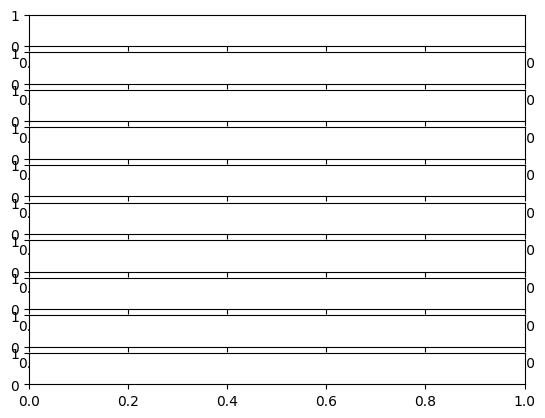

In [10]:
print(f"{len(folds)}-fold cross validation training")
print("-"*34)

fig, axs = plt.subplots(len(folds), 1)
for fold_idx, fold_bundle in enumerate(folds):
    print(f"Fold {fold_idx}:")
    train_ds = UrbanSoundDataSet(urban_audio_path, fold_bundle['train'])
    validation_ds = UrbanSoundDataSet(urban_audio_path, fold_bundle['validation'])
    print(f"\tSize of train, val datasets: {(len(train_ds), len(validation_ds))}")
    
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=isShuffle)
    validation_dl = DataLoader(validation_ds, batch_size=batch_size, shuffle=isShuffle)
    
    if preview:
        train_spectrograms, train_labels = next(iter(train_dl))
        spctr = train_spectrograms[0].squeeze()
        label = train_labels[0]
        plot_spectrogram(spctr, label, ax=axs[fold_idx])

fig.tight_layout()
        
        